In [69]:
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import alen, arange
import math
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

from sklearn.svm import SVR
#### PLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter

In [70]:
#BPSO

def pls_optimise_components(X, y, npc):
 
    rmsecv = np.zeros(npc)
    for i in range(1,npc+1,1):
 
        # Simple PLS
        pls_simple = PLSRegression(n_components=i)
        # Fit
        pls_simple.fit(X, y)
        #cv = LeaveOneOut()
        cv=10
        # Cross-validation
        y_cv = cross_val_predict(pls_simple, X, y, cv=cv)
 
        # Calculate scores
        score = r2_score(y, y_cv)
        rmsecv[i-1] = np.sqrt(mean_squared_error(y, y_cv))
 
    # Find the minimum of ther RMSE and its location
    opt_comp, rmsecv_min = np.argmin(rmsecv),  rmsecv[np.argmin(rmsecv)]
 
    return (opt_comp+1, rmsecv_min)

def base_pls(X,y,n_components, return_model=False):
 
    # Simple PLS
    pls_simple = PLSRegression(n_components=n_components)
    # Fit
    pls_simple.fit(X, y)
    cv = 10
    # Cross-validation
    y_cv = cross_val_predict(pls_simple, X, y, cv=cv)
 
    # Calculate scores
    score = r2_score(y, y_cv)
    rmsecv = np.sqrt(mean_squared_error(y, y_cv))
 
    if return_model == False:
        return(y_cv, score, rmsecv)
    else:
        return(y_cv, score, rmsecv, pls_simple)
    
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Create an instance 
#reg = linear_model.LinearRegression

# Define objective function
def f_per_particle(m, alpha):
    """Computes for the objective function per particle

    Inputs
    ------
    m : numpy.ndarray
        Binary mask that can be obtained from BinaryPSO, will
        be used to mask features.
    alpha: float (default is 0.5)
        Constant weight for trading-off classifier performance
        and number of features

    Returns
    -------
    numpy.ndarray
        Computed objective function
    """
    
    total_features = dimensions
    # Get the subset of the features from the binary mask

    #X_sav = savgol_filter(X_train, 3, polyorder=2, deriv=1)

    if np.count_nonzero(m) == 0:
        X_subset = X_train
    else:
        X_subset = X_train[:,m==1]

    
 

    # #regr = make_pipeline(StandardScaler(), SVR())
    # #regr = make_pipeline(StandardScaler(), RandomForestRegressor(max_depth=5, random_state=1))
    # #regr = make_pipeline(StandardScaler(), SVR(C = 0.5, degree= 1, kernel= 'rbf',epsilon= 0.16))
    # #X1 = savgol_filter(X_subset, 3, polyorder=2, deriv=1)
    # reg1 = GradientBoostingRegressor(random_state=1)
    # #reg2 = RandomForestRegressor(random_state=1)
    # opt_comp, rmsecv_min = pls_optimise_components(X_subset, y_train_oleo, 8)
    # reg3 = PLSRegression(n_components=opt_comp)
    # #reg3 = PLSRegression(n_components=5)
    # #reg3 = LinearRegression()
    # ereg = VotingRegressor(estimators=[('gb', reg1), ('plsr', reg3)])
    # ereg = ereg.fit(X_subset, y_train_oleo)
    # #regr.fit(X_subset, y_train_oleo)
    # y_pred = cross_val_predict(ereg, X_subset, y_train_oleo, cv=10)
    # #y_pred = ereg.predict(X_subset)
    # #y_pred = regr.predict(X1)
    # #r2cv = mean_squared_error(y_train_oleo, y_pred)
    # r2cv = r2_score(y_train_oleo, y_pred)
    # P = r2cv
    # #P = (classifier.predict(X_subset) == y).mean()
    # # Compute for the objective function
    # j = (alpha * (1.0 - P)
    #     + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))



    opt_comp, rmsecv_min = pls_optimise_components(X_subset, y_train_oleo, 8)
    predicted, r2cv, rmscv = base_pls(X_subset, y_train_oleo, opt_comp)
    
    P = r2cv
    #P = (classifier.predict(X_subset) == y).mean()
    # Compute for the objective function
    j = (alpha * (1.0 - P)
        + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))

    return j

def f(x, alpha=0.88):
    """Higher-level method to do classification in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

def msc(input_data):
     # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    

    # Calculate mean
    ref = np.mean(input_data, axis=0)

 
    # Define a new array and populate it with the corrected data    
    output_data= np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return output_data

In [71]:
df = pd.read_csv('Data/Wheat/Wheat_mean_NIR_data_65_samples.csv')

In [72]:
df.head()

,Sample,Batch,Order,TP,CUPRAC,FRAP,TMA,Moisture,Protein,999.8970106,...,2478.712814,2481.08483,2483.461389,2485.842505,2488.227573,2490.617843,2493.012709,2495.412185,2497.816284,2500.22502
0,W1,1,1,177.256315,366.709718,56.286815,0.000000,10.1,13.904338,0.264490,...,0.993593,0.996831,0.998601,1.000223,1.001534,1.001571,1.002851,1.004485,1.004250,1.002066
1,W2,1,2,153.408515,290.123902,53.543083,2.511161,8.7,14.786418,0.283164,...,1.031166,1.033582,1.035195,1.037318,1.038840,1.038373,1.038098,1.039568,1.039971,1.039888
2,W3,1,3,167.788770,433.513709,54.841090,0.235243,10.4,12.500000,0.276600,...,1.048032,1.050699,1.051539,1.053081,1.054179,1.054097,1.053567,1.053987,1.054386,1.052976
3,W4,1,4,161.171271,281.405362,57.062854,9.228084,11.6,14.819005,0.284350,...,1.066802,1.069377,1.071662,1.075393,1.077126,1.075814,1.075846,1.076120,1.076186,1.076950
4,W5,1,5,143.785691,309.539558,55.627153,0.590040,10.9,16.722783,0.294623,...,1.007914,1.010732,1.012537,1.013475,1.015025,1.014866,1.015861,1.016620,1.016702,1.016687


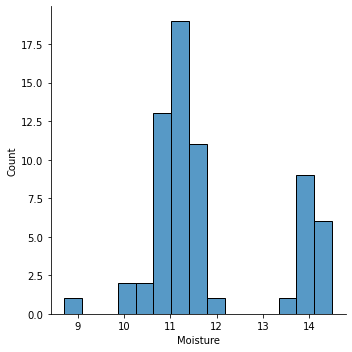

In [73]:
import seaborn as sns
sns.displot(df['Moisture'])

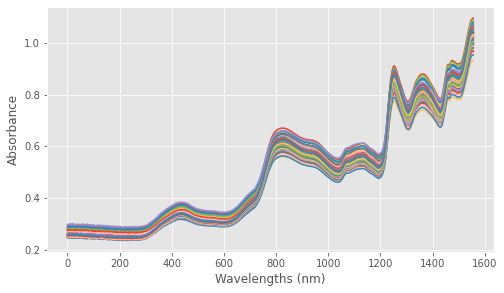

In [74]:
wl = np.arange(0, 1557, 1)
plt.figure(figsize=(8, 4.5))
with plt.style.context('ggplot'):
    plt.plot(wl, df.iloc[:,9:].values.T)
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")
    plt.show()

In [75]:
#df.iloc[:,9:] = snv(df.values[:,9:])
df_pretreat = df.iloc[:,9:]
df_pretreat['Umidade'] = df['Moisture']
df_pretreat['Protein'] = df['Protein']
df_pretreat['class'] = df_pretreat['Umidade'].astype(int)


for index, row in df_pretreat.iterrows():
    if row['Umidade']< 10.2:
        df_pretreat.loc[index, 'class'] = 8
df_pretreat

,999.8970106,1000.28298,1000.669047,1001.055413,1001.441976,1001.829039,1002.216201,1002.603862,1002.991623,1003.379885,...,2485.842505,2488.227573,2490.617843,2493.012709,2495.412185,2497.816284,2500.22502,Umidade,Protein,class
0,0.264490,0.265070,0.264313,0.265251,0.264319,0.264963,0.265600,0.265346,0.264630,0.264989,...,1.000223,1.001534,1.001571,1.002851,1.004485,1.004250,1.002066,10.1,13.904338,8
1,0.283164,0.284325,0.283624,0.284148,0.282205,0.281135,0.281490,0.281886,0.282097,0.282473,...,1.037318,1.038840,1.038373,1.038098,1.039568,1.039971,1.039888,8.7,14.786418,8
2,0.276600,0.277441,0.275031,0.276462,0.276817,0.276438,0.276419,0.276996,0.279289,0.279410,...,1.053081,1.054179,1.054097,1.053567,1.053987,1.054386,1.052976,10.4,12.500000,10
3,0.284350,0.286067,0.286507,0.286528,0.286619,0.286029,0.285122,0.286209,0.286949,0.287247,...,1.075393,1.077126,1.075814,1.075846,1.076120,1.076186,1.076950,11.6,14.819005,11
4,0.294623,0.296398,0.297447,0.295038,0.291319,0.292503,0.295399,0.297310,0.297976,0.297869,...,1.013475,1.015025,1.014866,1.015861,1.016620,1.016702,1.016687,10.9,16.722783,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.255387,0.256557,0.257468,0.256755,0.255548,0.255051,0.255576,0.256388,0.255947,0.256028,...,1.024929,1.026869,1.029787,1.029719,1.027954,1.026543,1.027072,14.0,14.186047,14
61,0.260055,0.261521,0.260796,0.261677,0.261635,0.258871,0.257091,0.258535,0.259138,0.260256,...,1.045070,1.046475,1.047091,1.047631,1.048851,1.049913,1.048571,14.1,14.318976,14
62,0.261027,0.262079,0.260400,0.259748,0.259618,0.258786,0.258932,0.257340,0.256873,0.259077,...,1.052203,1.054044,1.055173,1.055738,1.057897,1.059257,1.057239,14.2,13.986014,14
63,0.257334,0.258735,0.257742,0.256439,0.255940,0.255588,0.255329,0.255204,0.256131,0.255853,...,1.054979,1.056454,1.057531,1.059781,1.060897,1.059562,1.057915,14.2,13.869464,14


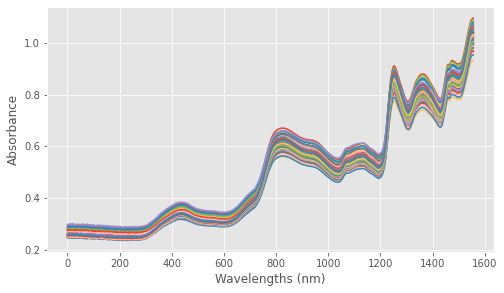

In [76]:
wl = np.arange(0, 1557, 1)
plt.figure(figsize=(8, 4.5))
with plt.style.context('ggplot'):
    plt.plot(wl, df_pretreat.iloc[:,:-3].values.T)
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")
    plt.show()

In [77]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



pca = PCA(n_components=5)
T = pca.fit_transform(df_pretreat.iloc[:,:-2])
df_pca = pd.DataFrame(T)
df_pca.rename(columns={0: 'PC1', 1: 'PC2', 2: 'PC3', 3: 'PC4', 4: 'PC5'}, inplace=True)

print(pca.explained_variance_ratio_)


[7.35605556e-01 2.52042792e-01 1.02671324e-02 9.25402519e-04
 5.39444511e-04]


In [26]:
import plotly.express as px

fig = px.scatter(df_pca, x='PC1', y='PC2', render_mode='svg')

fig.show()

In [44]:
df_pretreat.describe()

,999.8970106,1000.28298,1000.669047,1001.055413,1001.441976,1001.829039,1002.216201,1002.603862,1002.991623,1003.379885,...,2483.461389,2485.842505,2488.227573,2490.617843,2493.012709,2495.412185,2497.816284,2500.22502,Umidade,Protein
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,...,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,0.262450,0.263598,0.263188,0.262685,0.262942,0.262787,0.263007,0.262583,0.262511,0.263006,...,1.019769,1.021549,1.023116,1.023843,1.024174,1.024359,1.024523,1.024243,11.851231,14.114709
std,0.013381,0.013966,0.014161,0.013803,0.013159,0.013293,0.013934,0.014699,0.015194,0.014817,...,0.032673,0.032854,0.032833,0.032685,0.032748,0.032733,0.032808,0.032759,1.358467,2.029961
min,0.248124,0.247141,0.246445,0.247026,0.248580,0.248597,0.248738,0.246566,0.246000,0.246762,...,0.927884,0.928114,0.930028,0.930709,0.930913,0.930114,0.931235,0.932131,8.700000,10.664571
25%,0.252859,0.254145,0.254103,0.253420,0.253875,0.254010,0.253906,0.252606,0.251943,0.252630,...,0.998032,0.999681,1.000850,1.001571,1.002568,1.002324,1.002347,1.001487,11.000000,12.008979
50%,0.257334,0.258076,0.257427,0.256755,0.257451,0.257088,0.257091,0.256388,0.255814,0.256028,...,1.021560,1.024043,1.026266,1.026563,1.027050,1.027214,1.026543,1.025906,11.400000,13.885648
75%,0.264490,0.265769,0.265144,0.265251,0.264319,0.265047,0.265600,0.265346,0.264630,0.264989,...,1.042488,1.045070,1.046475,1.047099,1.047631,1.047026,1.047125,1.048571,11.800000,16.478555
max,0.297521,0.300073,0.300032,0.299144,0.299168,0.298542,0.299683,0.300385,0.300661,0.300363,...,1.089120,1.090794,1.091733,1.092713,1.094012,1.093522,1.093375,1.094220,14.500000,17.463849


In [14]:
# df_pretreat['class'] = 0
# for index, row in df_pretreat.iterrows():
#     if row['Umidade'] < 11:
#         df_pretreat.loc[index, 'class'] = 0
#     elif row['Umidade'] < 11.4:
#         df_pretreat.loc[index, 'class'] = 1
#     elif row['Umidade'] < 11.8:
#         df_pretreat.loc[index, 'class'] = 2
#     else:
#         df_pretreat.loc[index, 'class'] = 3

In [ ]:
# df_pretreat['class'] = 0
# for index, row in df_pretreat.iterrows():
#     if row['Umidade'] < 10.5:
#         df_pretreat.loc[index, 'class'] = 0
#     elif row['Umidade'] < 11.4:
#         df_pretreat.loc[index, 'class'] = 1
#     elif row['Umidade'] < 11.8:
#         df_pretreat.loc[index, 'class'] = 2
#     else:
#         df_pretreat.loc[index, 'class'] = 3

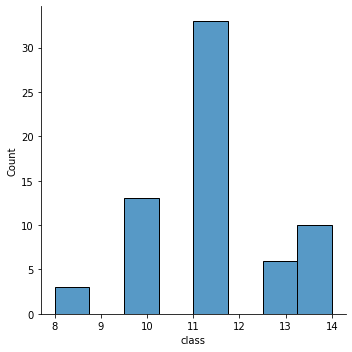

In [36]:
import seaborn as sns
sns.displot(df_pretreat['class'])

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


y = df_pretreat[['Umidade','Protein','class']]
## Do not take the reference value and the class
X = df_pretreat.values[:, :-2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0,stratify=y['class'])


# col = [0,3,5,8,10,12,20,21,25,28,29,34,35,38,39,40,45,46,47,49,50,51,53,57,58,62,63,67,70,71,73,74,80,83,90,93,97,99,100,103,104,106,108,110,113,115,116,117,118,119,121,122,124,125,126,128,132,134,136,137,138,143,147,149,154,158,164,166,168,169,176,178,179,180,182,183,185,188,190,195,197,202,205,212,214,216,227,241,242,246,247,249,250,253,255,258,260,265,267,269,272,273,274,279,286,290,292,295,296,299,301,302,303,305,306,309,310,318,323,324,325,327,328,331,333,335,338,345,347,348,350,351,353,360,361,368,371,373,374,375,379,380,383,384,386,395,399,401,402,403,406,413,414,416,417,421,422,423,424,426,429,431,437,440,441,445,452,454,457,461,462,463,465,466,467,468,473,475,478,481,482,483,485,487,491,493,494,499,508,511,527,528,529,537,539,542,547,555,558,559,562,567,571,573,575,578,579,585,589,591,595,597,598,600,601,602,603,605,613,619,620,622,623,629,631,632,633,635,636,639,640,641,644,646,649,650,652,653,655,656,657,658,662,665,667,668,674,675,680,684,686,688,692,696,699,705,706,711,714,718,723,724,725,726,727,728,730,733,734,735,736,737,738,739,740,743,744,748,750,751,754,756,758,760,761,765,766,770,772,773,774,775,778,782,783,787,791,797,803,805,807,808,812,813,817,820,821,823,827,828,834,835,837,839,840,845,850,853,854,855,857,858,861,863,866,871,873,875,877,879,884,885,886,887,891,893,895,899,904,905,910,916,917,918,922,923,925,926,927,931,932,933,936,940,941,944,946,950,951,956,958,960,962,966,968,972,974,975,982,986,987,995,996,997,998,999,1001,1003,1010,1011,1013,1015,1016,1018,1020,1022,1024,1029,1031,1035,1040,1041,1043,1044,1045,1049,1058,1060,1064,1065,1066,1067,1068,1070,1071,1072,1079,1082,1084,1088,1090,1095,1096,1106,1110,1118,1125,1126,1128,1129,1130,1134,1135,1138,1144,1150,1152,1157,1158,1161,1164,1167,1168,1170,1172,1174,1176,1177,1180,1183,1185,1186,1187,1188,1191,1198,1199,1201,1203,1208,1209,1211,1215,1219,1223,1224,1225,1229,1232,1235,1242,1243,1244,1247,1248,1250,1256,1257,1261,1276,1277,1279,1280,1283,1287,1289,1291,1295,1298,1299,1301,1302,1306,1308,1310,1314,1315,1316,1320,1322,1323,1324,1326,1327,1328,1335,1336,1340,1345,1346,1348,1349,1351,1355,1356,1358,1362,1363,1364,1365,1368,1369,1374,1378,1379,1380,1383,1385,1387,1388,1391,1392,1393,1400,1407,1411,1412,1415,1417,1418,1423,1425,1428,1429,1431,1432,1433,1437,1443,1448,1449,1450,1451,1453,1457,1459,1461,1463,1468,1470,1472,1474,1475,1477,1481,1482,1486,1490,1491,1492,1495,1496,1498,1499,1502,1505,1506,1508,1509,1511,1512,1514,1515,1516,1518,1519,1521,1522,1531,1533,1536,1542,1543,1544,1546,1547,1549,1550,1553]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))

# col = [0,   1,   2,   8,   9,  12,  15,  17,  18,  20,  21,  22,  24,
#         31,  34,  36,  37,  39,  40,  41,  42,  44,  45,  46,  48,  50,
#         52,  53,  54,  55,  58,  61,  65,  68,  71,  72,  75,  80,  81,
#         82,  89,  90,  91,  92,  95,  98, 103, 106, 109, 112, 118, 122,
#        124, 125, 128, 133, 135, 137, 139, 148, 149, 153, 155, 156, 158,
#        161, 162, 167, 173, 174, 175, 176, 177, 178, 181, 183, 185, 186,
#        187, 188, 192, 198, 199, 203, 210, 216, 217, 219, 221, 224, 225,
#        228, 229, 231, 232, 238, 240, 242, 246, 247, 248, 252, 253, 254,
#        257, 261, 268, 269, 270, 272, 273, 275, 277, 280, 282, 284, 286,
#        287, 289, 293, 295, 296, 297, 300, 305, 306, 315, 316, 317, 318,
#        319, 320, 325, 327, 332, 334, 336, 339, 342, 347, 351, 352, 353,
#        356, 358, 360, 363, 365, 369, 373, 374, 375, 378, 379, 382, 386,
#        387, 392, 393, 395, 403, 407, 411, 414, 416, 418, 427, 428, 429,
#        434, 436, 440, 442, 444, 446, 449, 450, 451, 454, 457, 460, 464,
#        465, 467, 469, 470, 473, 475, 476, 477, 478, 480, 481, 483, 487,
#        491, 494, 497, 502, 504, 505, 506, 514, 516, 517, 518, 520, 522,
#        523, 533, 535, 538, 541, 543, 544, 546, 547, 549, 550, 552, 558,
#        560, 562, 564, 565, 567, 568, 569, 570, 571, 572, 574, 577, 578,
#        580, 594, 597, 598, 602, 604, 607, 611, 613, 614, 616, 625, 627,
#        628, 630, 631, 633, 634, 636, 640, 641, 642, 653, 670, 672, 675,
#        676, 678, 679, 680, 683, 684, 686, 689, 692, 695, 696, 699, 701,
#        703, 704, 705, 709, 710, 714, 715, 717, 718, 722, 723, 730, 736,
#        739, 740, 742, 743, 745, 749, 752, 756, 759, 760, 766, 770, 775,
#        777, 780, 784, 786, 794, 795, 797, 798, 800, 802, 804, 806, 807,
#        810, 814, 818, 820, 826, 827, 828, 830, 832, 836, 838, 841, 846,
#        848, 851, 852, 858, 859, 863, 866, 868, 872, 873, 875, 880, 883,
#        884, 888, 889, 892, 893, 895, 899, 901, 906, 907, 910, 915, 921,
#        924, 925, 928, 929, 931, 933, 934, 947, 954, 960, 965, 966]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))

# col = [1,   2,   4,   6,   7,  11,  12,  13,  22,  24,  25,  26,  30,
#         36,  42,  44,  51,  57,  61,  62,  64,  71,  72,  75,  78,  80,
#         81,  84,  86,  89,  94,  95, 101, 105, 106, 110, 111, 113, 114,
#        116, 117, 124, 125, 135, 136, 137, 140, 144, 146, 149, 152, 153,
#        154, 156, 157, 158, 159, 161, 164, 167, 171, 176, 178, 181, 189,
#        190, 192, 194, 200, 204, 208, 210, 211, 217, 222, 223, 224, 225,
#        227, 228, 230, 232, 236, 237, 239, 242, 246, 247, 260, 262, 263,
#        266, 267, 271, 273, 276, 283, 285, 292, 294, 296, 297, 298, 299,
#        300, 301, 302, 306, 309, 316, 317, 319, 321, 324, 325, 334, 335,
#        336, 338, 339, 342, 345, 346, 348, 350, 353, 354, 355, 356, 357,
#        359, 364, 367, 370, 378, 380, 383, 384, 385, 387, 391, 392, 393,
#        394, 395, 398, 399, 400, 405, 407, 409, 414, 417, 419, 434, 440,
#        443, 444, 447, 449, 450, 451, 453, 456, 458, 461, 464, 465, 469,
#        473, 475, 476, 480, 486, 490, 496, 497, 498, 499, 505, 512, 514,
#        516, 518, 525, 528, 530, 536, 540, 542, 544, 545, 546, 557, 558,
#        559, 568, 569, 571, 572, 578, 583, 584, 589, 595, 601]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))

# col = [3,   4,   6,   7,  15,  20,  21,  26,  29,  32,  33,  35,  38,
#         42,  43,  52,  53,  55,  62,  63,  66,  67,  68,  74,  76,  83,
#         85,  92,  93,  96, 100, 108, 113, 116, 117, 119, 120, 121, 123,
#        124, 126, 127, 129, 130, 133, 137, 138, 139, 142, 144, 147, 148,
#        150, 152, 155, 162, 164, 165, 169, 170, 178, 186, 192, 197, 199,
#        206, 209, 211, 213, 219, 227, 229, 230, 238, 240, 244, 245, 250,
#        251, 255, 261, 263, 265, 266, 267, 271, 272, 273, 274, 277, 278,
#        283, 289, 292, 296, 299, 301, 308, 309, 313, 315, 316, 318, 320,
#        321, 323, 325, 329, 331, 341, 344, 353, 357, 365, 366, 369, 378,
#        380, 389, 391, 394, 395, 397]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X_train_snv = msc(X_train)
# X_#test_snv = msc(X_test)

y_train_oleo = y_train['Umidade']


y_test_oleo = y_test['Umidade']

#X1 = savgol_filter(X_train, 23, polyorder=2, deriv=2)
#X2 = savgol_filter(X_test, 23, polyorder=2, deriv=2)

# X_train_snv = msc(X_train)
# X_test_snv = msc(X_test)

# mean centre correction
#X_mc = mc(X1)

##Standard Normal Variate

# Xsnv = snv(X_train)

In [66]:
##SNV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


y = df_pretreat[['Umidade','Protein','class']]
## Do not take the reference value and the class
X = df_pretreat.values[:, :-2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0,stratify=y['class'])


col = [1,4,11,12,14,16,18,21,23,27,30,31,32,33,34,36,38,40,41,44,45,46,49,52,53,55,56,57,65,67,68,69,71,72,73,75,82,84,85,94,97,98,104,106,111,116,119,120,121,122,126,129,130,133,134,135,144,147,149,153,155,157,161,162,164,165,167,168,170,171,172,174,175,179,180,182,183,184,185,187,189,191,192,193,196,197,198,200,201,202,204,205,207,208,209,211,212,215,217,218,219,222,223,225,226,232,234,235,237,238,241,243,244,247,250,253,254,255,256,258,260,262,264,265,267,270,271,275,278,280,284,288,290,293,295,296,297,298,300,302,303,306,309,311,313,314,316,318,319,320,322,324,325,328,329,330,332,334,335,343,345,346,347,349,351,354,355,356,358,360,364,365,366,369,370,372,373,374,375,376,377,378,382,386,388,389,390,391,394,395,397,401,403,407,408,410,411,413,415,417,418,419,420,421,424,425,426,428,429,431,432,433,435,436,438,439,440,441,442,445,447,448,451,454,455,456,459,460,462,463,465,466,467,468,472,473,475,480,481,482,484,485,488,489,491,493,496,497,498,500,501,503,507,511,512,513,514,515,520,521,525,528,530,531,534,536,539,540,541,544,545,547,553,554,555,556,557,562,563,564,565,567,568,569,570,571,572,577,581,582,583,585,587,588,589,591,592,596,597,599,600,601,602,603,606,608,609,610,612,613,614,618,620,622,625,626,630,631,633,635,637,638,641,644,646,648,650,651,652,653,657,658,659,662,664,666,671,672,673,676,677,678,680,681,685,686,687,688,691,696,697,700,701,703,707,709,713,714,715,716,717,718,721,723,729,730,733,735,736,740,744,745,748,750,751,754,756,760,763,764,767,768,773,776,777,778,779,781,783,784,785,786,787,789,790,794,796,799,800,801,806,809,810,811,814,815,816,821,827,829,831,832,836,837,841,843,844,845,846,849,858,861,862,864,866,867,868,869,870,874,876,880,881,882,883,886,890,893,897,898,899,900,904,905,909,911,913,918,920,925,926,929,931,933,934,938,941,942,944,945,946,947,952,954,956,958,960,961,964,967,970,971,972,975,978,980,981,982,985,987,988,989,994,995,996,997,1001,1003,1004,1005,1009,1011,1012,1016,1017,1019,1023,1028,1029,1031,1033,1034,1037,1038,1039,1045,1049,1052,1053,1054,1056,1057,1058,1059,1060,1062,1064,1065,1068,1069,1073,1076,1079,1081,1089,1090,1091,1094,1096,1098,1099,1100,1101,1103,1104,1106,1109,1110,1112,1116,1117,1122,1123,1124,1127,1129,1130,1131,1135,1136,1138,1139,1143,1150,1151,1153,1156,1160,1161,1162,1163,1164,1166,1168,1169,1172,1174,1175,1176,1181,1183,1186,1190,1191,1194,1196,1198,1199,1200,1202,1205,1207,1211,1212,1213,1214,1215,1216,1218,1219,1220,1221,1222,1223,1224,1226,1227,1228,1229,1230,1232,1235,1236,1237,1238,1239,1241,1242,1246,1248,1250,1252,1255,1257,1258,1259,1262,1263,1265,1270,1274,1275,1276,1277,1282,1287,1288,1289,1290,1294,1296,1298,1300,1304,1307,1308,1310,1311,1312,1313,1315,1318,1321,1323,1326,1327,1330,1332,1339,1340,1343,1344,1347,1348,1349,1351,1352,1354,1355,1356,1357,1359,1360,1361,1367,1368,1369,1371,1372,1375,1376,1377,1378,1380,1381,1385,1390,1391,1392,1393,1394,1395,1396,1398,1401,1405,1408,1409,1413,1416,1418,1419,1420,1426,1427,1433,1434,1437,1440,1441,1442,1444,1445,1448,1449,1450,1452,1455,1457,1458,1459,1461,1466,1467,1469,1470,1472,1473,1477,1478,1481,1483,1486,1490,1491,1492,1493,1494,1497,1498,1499,1501,1503,1505,1506,1507,1508,1512,1513,1514,1516,1517,1521,1527,1529,1532,1535,1537,1539,1541,1542,1543,1547,1548,1550,1553,1555]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [ 1,   2,   3,   4,   6,  10,  11,  15,  16,  18,  20,  21,  22,
        23,  24,  26,  27,  29,  31,  32,  33,  35,  37,  39,  40,  44,
        48,  52,  57,  59,  60,  62,  63,  67,  69,  70,  72,  76,  77,
        78,  79,  83,  84,  87,  88,  89,  90,  91,  92,  93,  95,  98,
        99, 103, 106, 107, 112, 115, 116, 119, 121, 122, 123, 124, 125,
       128, 130, 131, 132, 133, 134, 136, 137, 138, 140, 144, 149, 156,
       159, 164, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 182,
       184, 185, 186, 188, 189, 191, 192, 194, 195, 196, 199, 200, 205,
       206, 207, 208, 210, 211, 212, 214, 215, 216, 217, 220, 221, 223,
       226, 228, 229, 230, 231, 233, 235, 236, 242, 245, 246, 247, 249,
       250, 251, 253, 255, 261, 263, 264, 265, 270, 271, 273, 274, 275,
       280, 281, 282, 284, 285, 289, 293, 295, 306, 307, 312, 313, 316,
       319, 321, 323, 328, 329, 330, 331, 338, 339, 340, 342, 343, 344,
       345, 346, 347, 349, 352, 355, 356, 357, 359, 361, 367, 371, 372,
       377, 378, 384, 388, 389, 394, 395, 397, 398, 399, 400, 405, 406,
       407, 409, 410, 418, 424, 425, 426, 428, 430, 431, 435, 436, 437,
       438, 439, 440, 442, 443, 446, 449, 451, 453, 454, 455, 457, 459,
       460, 463, 464, 466, 468, 474, 475, 476, 478, 479, 481, 482, 488,
       489, 490, 491, 495, 497, 503, 504, 505, 506, 507, 508, 510, 513,
       516, 517, 518, 520, 521, 523, 525, 527, 529, 534, 536, 537, 541,
       544, 545, 546, 547, 548, 549, 551, 552, 555, 559, 560, 561, 563,
       564, 565, 566, 573, 574, 575, 576, 577, 579, 580, 581, 583, 587,
       592, 593, 594, 602, 603, 604, 607, 608, 609, 612, 614, 615, 617,
       620, 621, 624, 628, 629, 630, 636, 640, 642, 646, 647, 648, 650,
       651, 654, 656, 657, 658, 660, 668, 671, 674, 675, 677, 678, 680,
       681, 684, 686, 687, 688, 689, 690, 691, 692, 694, 695, 696, 698,
       699, 708, 710, 711, 714, 715, 716, 717, 719, 721, 722, 724, 727,
       732, 733, 737, 740, 742, 743, 749, 752, 755, 756, 758, 759, 760,
       761, 763, 764, 767, 770, 771, 776, 777, 778, 780, 781, 782, 788,
       789, 790, 791, 792, 795]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [5,   8,  10,  11,  13,  14,  22,  23,  25,  27,  28,  29,  30,
        33,  34,  36,  40,  42,  44,  45,  46,  50,  52,  55,  56,  57,
        59,  60,  64,  66,  67,  68,  71,  72,  73,  74,  81,  82,  84,
        86,  90,  92,  94,  99, 100, 102, 103, 105, 108, 113, 114, 118,
       120, 122, 124, 129, 132, 134, 136, 137, 139, 140, 141, 148, 150,
       156, 160, 163, 174, 176, 180, 182, 183, 186, 187, 189, 190, 192,
       194, 197, 205, 211, 212, 216, 218, 220, 223, 225, 227, 229, 230,
       233, 239, 240, 242, 245, 255, 256, 257, 260, 264, 266, 267, 272,
       274, 278, 283, 286, 288, 292, 293, 296, 297, 301, 305, 306, 307,
       310, 311, 312, 319, 321, 323, 326, 327, 328, 329, 331, 334, 337,
       341, 342, 344, 348, 349, 351, 352, 353, 358, 359, 360, 363, 364,
       366, 367, 370, 371, 373, 374, 376, 377, 380, 383, 384, 387, 388,
       392, 393, 395, 396, 398, 399, 400, 405, 411, 416]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [0,  13,  15,  16,  20,  21,  22,  23,  27,  29,  30,  31,  32,
        37,  41,  47,  48,  50,  58,  60,  62,  63,  64,  66,  69,  70,
        73,  79,  84,  87,  89, 105, 106, 109, 110, 114, 119, 122, 124,
       127, 129, 136, 137, 141, 142, 143, 144, 146, 151, 155, 158, 160,
       163, 165, 167, 169, 170, 177, 185, 186, 188, 189, 192, 199, 204,
       209, 211, 220, 224, 225, 231, 234, 238, 239, 241, 242, 244, 245,
       251]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [1,   2,   4,  10,  16,  23,  24,  27,  28,  31,  36,  37,  38,
        39,  46,  47,  48,  50,  55,  57,  60,  65,  66,  70,  72,  76,
        77,  79,  88,  89,  93,  98,  99, 100, 101, 105, 107, 120, 121,
       129, 137, 141, 142, 144, 154, 161, 164, 170]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [0,   9,  13,  16,  22,  33,  39,  51,  56,  59,  65,  73,  75,
        80,  82,  84,  85,  86,  94,  97, 102, 108, 109, 110, 111, 114,
       121]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [7, 12, 17, 21, 23, 27, 30, 31, 34, 47, 50, 59, 62, 66, 70, 80]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))


#X_train_snv = msc(X_train)
#X_test_snv = msc(X_test)

y_train_oleo = y_train['Umidade']


y_test_oleo = y_test['Umidade']

#X1 = savgol_filter(X_train, 23, polyorder=2, deriv=2)
#X2 = savgol_filter(X_test, 23, polyorder=2, deriv=2)

# X_train_snv = msc(X_train)
# X_test_snv = msc(X_test)

# mean centre correction
#X_mc = mc(X1)

##Standard Normal Variate

# Xsnv = snv(X_train)

In [155]:
##sans pretraitement
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


y = df_pretreat[['Umidade','Protein','class']]
## Do not take the reference value and the class
X = df_pretreat.values[:, :-2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0,stratify=y['class'])


col = [1,5,11,15,19,20,21,22,27,30,32,34,35,36,37,38,39,43,45,48,52,55,56,59,60,61,66,67,68,71,72,76,80,85,86,88,90,91,93,94,95,97,99,100,102,104,105,107,110,114,115,118,120,123,127,128,129,130,131,133,134,142,143,144,147,151,152,155,157,158,160,161,164,165,166,167,168,169,171,176,179,181,184,185,186,187,188,189,199,200,210,211,220,221,222,228,230,232,234,236,239,240,241,245,246,247,252,253,256,257,260,261,263,265,266,268,269,272,273,275,277,280,283,285,287,290,291,293,295,298,301,303,308,310,311,314,317,319,328,331,334,341,342,349,350,351,353,355,357,358,359,360,362,368,372,377,378,379,380,383,385,388,389,390,394,401,403,407,408,410,414,418,420,422,423,425,427,428,430,431,433,434,436,438,441,447,448,454,459,465,467,471,472,475,476,481,484,485,487,489,491,493,494,495,503,505,507,509,511,513,515,516,518,519,520,522,527,528,530,534,535,536,542,544,546,552,559,567,578,581,585,589,590,601,602,614,615,616,617,618,619,620,622,623,624,625,627,630,633,634,636,637,642,645,647,653,657,658,659,661,662,663,664,666,668,669,674,683,686,688,692,694,696,698,703,706,709,710,713,715,720,721,725,726,727,728,729,730,731,733,734,736,737,739,741,742,744,746,750,755,756,761,763,765,773,774,778,779,780,781,785,786,788,790,794,795,796,797,798,801,805,813,814,817,818,819,820,829,830,832,833,834,835,837,845,846,848,849,850,851,854,855,857,859,861,863,865,868,871,873,876,878,879,880,887,888,889,896,900,903,904,907,911,912,914,918,919,928,930,932,937,942,944,946,948,950,952,953,958,961,964,968,971,978,981,984,988,989,990,994,996,999,1002,1003,1005,1010,1013,1014,1017,1020,1023,1028,1030,1033,1036,1039,1040,1041,1043,1044,1047,1048,1049,1051,1053,1055,1061,1064,1065,1071,1075,1078,1081,1083,1084,1086,1088,1090,1095,1101,1103,1110,1111,1115,1118,1120,1121,1125,1132,1135,1136,1142,1144,1147,1151,1154,1155,1156,1158,1162,1163,1164,1167,1171,1172,1173,1174,1175,1177,1182,1187,1191,1195,1197,1202,1203,1207,1210,1213,1225,1229,1232,1234,1235,1236,1237,1240,1242,1243,1251,1252,1254,1255,1258,1261,1264,1270,1271,1273,1274,1275,1276,1278,1282,1284,1286,1287,1288,1290,1296,1299,1300,1301,1303,1305,1306,1307,1308,1310,1311,1314,1318,1319,1321,1323,1324,1326,1327,1329,1332,1334,1335,1336,1345,1348,1353,1357,1358,1362,1364,1365,1370,1373,1377,1380,1382,1384,1388,1390,1392,1398,1399,1404,1407,1408,1411,1412,1413,1414,1416,1417,1420,1422,1423,1426,1431,1437,1438,1439,1445,1447,1448,1449,1454,1456,1460,1461,1462,1463,1464,1465,1469,1474,1476,1478,1480,1481,1484,1488,1498,1499,1503,1504,1506,1507,1508,1511,1516,1517,1518,1520,1521,1522,1523,1526,1531,1532,1539,1540,1541,1544,1546,1550,1551,1555]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [ 2,   7,   9,  12,  13,  22,  23,  25,  28,  30,  35,  43,  45,
        46,  56,  64,  65,  71,  76,  82,  83,  86,  87,  90,  93,  98,
       103, 106, 108, 109, 115, 116, 126, 127, 133, 136, 137, 139, 140,
       143, 149, 150, 156, 161, 162, 164, 168, 170, 171, 173, 175, 177,
       180, 181, 183, 184, 189, 190, 198, 205, 210, 213, 216, 217, 218,
       224, 226, 227, 231, 234, 236, 237, 241, 244, 245, 247, 249, 250,
       252, 253, 255, 256, 257, 258, 261, 265, 266, 267, 273, 275, 277,
       278, 280, 282, 283, 285, 286, 288, 289, 290, 291, 292, 295, 297,
       298, 300, 302, 306, 310, 312, 316, 317, 319, 321, 324, 329, 332,
       336, 339, 344, 345, 347, 348, 349, 352, 354, 355, 356, 359, 360,
       361, 362, 365, 369, 375, 379, 381, 383, 386, 387, 389, 390, 392,
       393, 394, 403, 404, 410, 414, 416, 418, 420, 422, 425, 432, 433,
       434, 438, 441, 442, 443, 445, 446, 447, 453, 456, 459, 461, 467,
       468, 470, 471, 472, 476, 480, 481, 490, 491, 492, 493, 496, 498,
       499, 500, 505, 506, 508, 509, 511, 512, 515, 517, 524, 525, 526,
       532, 533, 535, 536, 538, 539, 541, 542, 543, 544, 547, 549, 551,
       552, 553, 556, 559, 560, 561, 565, 566, 567, 570, 572, 577, 579,
       581, 583, 586, 587, 590, 594, 597, 602, 603, 604, 607, 608, 612,
       615, 616, 622, 628, 638, 639, 644, 645, 646, 650, 653, 655, 657,
       658, 659, 668, 669, 671, 673, 674, 675, 677, 678, 679, 682, 685,
       691, 692, 693, 698, 700, 701, 702, 704, 705, 706, 707, 708, 712,
       714, 718, 723, 728, 729, 730, 732, 739, 740, 741, 743, 749, 750,
       751, 752, 753, 754, 758, 759, 762, 764, 766, 772, 779, 780, 782,
       784, 786, 789, 791, 798, 799, 807, 809, 812, 818, 822, 826, 840,
       841, 843, 846, 848, 849, 854, 860, 861, 868, 870, 873, 874, 884,
       887, 889, 890, 896, 898, 899, 900, 901, 903, 904, 905, 910, 913,
       915, 917, 921, 923, 926, 927, 930, 932, 933, 941, 946, 950]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [0,   2,   4,   7,   9,  10,  11,  16,  20,  21,  28,  30,  34,
        35,  36,  37,  40,  43,  46,  47,  48,  50,  52,  53,  56,  57,
        59,  64,  66,  67,  72,  73,  87,  89,  93,  96, 103, 106, 112,
       114, 115, 116, 117, 118, 119, 121, 124, 125, 126, 129, 134, 136,
       137, 141, 144, 149, 150, 158, 160, 161, 164, 172, 180, 181, 186,
       187, 190, 194, 196, 197, 205, 207, 211, 215, 216, 223, 224, 225,
       226, 233, 234, 236, 237, 242, 252, 255, 257, 258, 259, 263, 265,
       267, 270, 271, 272, 273, 275, 281, 282, 284, 287, 288, 289, 290,
       295, 298, 300, 302, 303, 306, 307, 313, 314, 315, 319, 322, 323,
       324, 325, 330, 332, 333, 338, 339, 350, 351, 352, 353, 354, 357,
       361, 365, 368, 371, 377, 386, 389, 391, 393, 404, 405, 410, 412,
       413, 419, 423, 424, 427, 430, 433, 436, 438, 441, 442, 444, 447,
       451, 457, 460, 462, 465, 466, 470, 472, 474, 476, 479, 481, 484,
       486, 488, 496, 497, 499, 501, 505, 506, 508, 510, 511, 514, 516,
       519, 522, 524, 525, 526, 528, 529, 533, 535, 537, 538, 539, 542,
       547, 557, 559, 561, 563, 567, 571, 572, 574, 578, 582, 589, 590,
       594, 595, 596, 598]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [ 5,   9,  11,  13,  14,  15,  18,  19,  22,  25,  27,  29,  30,
        31,  40,  41,  43,  44,  45,  50,  51,  52,  56,  62,  64,  65,
        70,  73,  75,  77,  79,  80,  84,  87,  92,  93,  96, 104, 107,
       108, 114, 115, 119, 121, 123, 125, 127, 129, 133, 140, 143, 146,
       149, 152, 153, 155, 164, 166, 168, 172, 175, 179, 180, 181, 185,
       188, 193, 198, 199, 200, 202, 203, 207, 213, 214, 218, 219, 224,
       229, 230, 233, 240, 243, 245, 246, 247, 249, 253, 264, 267, 269,
       275, 276, 277, 278, 279, 283, 284, 289, 291, 292, 296, 297, 298,
       301, 304, 305, 310, 312, 317, 319, 321, 328, 330, 331, 332, 342,
       343, 346, 351, 358, 363, 364, 366, 369, 370, 372, 374, 375, 381,
       382]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [5,  11,  23,  27,  28,  30,  35,  36,  38,  39,  43,  47,  53,
        55,  56,  61,  63,  70,  72,  81,  85,  94, 100, 105, 106, 107,
       109, 114, 120, 123, 129, 131, 136, 141, 144, 147, 150, 152, 153,
       159, 162, 163, 168, 172, 173, 178, 179, 181, 183, 185, 189, 190,
       192, 202, 213, 214, 220, 222, 227, 229, 231, 233, 234, 236, 239,
       240, 241, 242, 245, 248, 256]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [ 0,   1,   5,  18,  25,  30,  35,  40,  42,  44,  45,  62,  65,
        66,  68,  75,  87,  90,  94, 112, 113, 114, 120, 122, 126, 128,
       130, 131, 137, 139, 142, 148, 151, 154, 158, 160, 162, 165, 168,
       170, 171, 172, 181, 186]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [19,  27,  33,  36,  39,  43,  44,  53,  55,  58,  61,  62,  64,
        65,  67,  74,  75,  77,  78,  91,  97, 103, 109, 110, 114, 126,
       134, 142]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [ 5,  9, 10, 13, 22, 36, 38, 39, 42, 48, 55, 65, 66, 71, 72, 83, 89,
       94]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [ 8, 11, 13, 21, 23, 34, 37, 38, 49, 51, 62, 63, 67, 78, 80, 82, 89]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [ 4, 12, 16, 24, 27, 34, 42, 62, 68, 75]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [ 2, 12, 28, 40, 43, 48, 63, 64]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [ 4, 25, 43, 46, 47, 49, 61]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [ 1,  4,  5, 29, 31, 34, 55]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [12, 48]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [16, 20, 46]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [4, 23, 36]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [8, 14]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))

col = [2,  5, 12]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))




#X_train_snv = msc(X_train)
#X_test_snv = msc(X_test)

y_train_oleo = y_train['Umidade']


y_test_oleo = y_test['Umidade']

#X1 = savgol_filter(X_train, 23, polyorder=2, deriv=2)
#X2 = savgol_filter(X_test, 23, polyorder=2, deriv=2)

# X_train_snv = msc(X_train)
# X_test_snv = msc(X_test)

# mean centre correction
#X_mc = mc(X1)

##Standard Normal Variate

# Xsnv = snv(X_train)

In [157]:
# Import PySwarms
import pyswarms as ps

# Initialize swarm, arbitrary
options = {'c1': 2, 'c2': 2, 'w':0.9, 'k': 20, 'p':2}

# Call instance of PSO
dimensions = X_train.shape[1] # dimensions should be the number of features

optimizer = ps.discrete.BinaryPSO(n_particles=20, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=100, verbose=2)
optimizer.reset()

2023-05-02 16:45:32,738 - pyswarms.discrete.binary - INFO - Optimize for 100 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 20, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|100/100, best_cost=1.18e-6
2023-05-02 16:51:26,973 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 1.1780592794519151e-06, best pos: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [158]:
np.where(pos == 0)[0]

array([], dtype=int64)

In [81]:
with open("Col_to_delete_2023-05-02_Wheat_moisture_X.txt", "w") as txt_file:
    for line in np.where(pos == 0)[0]:
        txt_file.write(str(line)+',')

In [40]:
X.shape

(48, 277)

In [156]:
ls_score_pls = []
n_opt = 8
for i in range(3,9):
    pls_simple = PLSRegression(n_components=i)
    cv = LeaveOneOut()
    #cv = 10

    X1 = X_train 
    #X1 = X_train[:,pos==1] 

    X2 = X_test
    #X2 = X_test[:,pos==1] 


    # Fit
    pls_simple.fit(X1, y_train_oleo)


    # Cross-validation
    y_cv = cross_val_predict(pls_simple,X1, y_train_oleo, cv=cv)
    y_pred = pls_simple.predict(X2)
    score = r2_score(y_train_oleo, y_cv)
    if ls_score_pls:
        if score< ls_score_pls[-1] and i>4:
            n_opt =  i-1
            break

    ls_score_pls.append(score)

pls_simple = PLSRegression(n_components=n_opt)
cv = LeaveOneOut()
# cv = 10

X1 = X_train 
#X1 = X_train[:,pos==1] 

X2 = X_test
#X2 = X_test[:,pos==1] 


# Fit
pls_simple.fit(X1, y_train_oleo)


# Cross-validation
y_cv = cross_val_predict(pls_simple,X1, y_train_oleo, cv=cv)
y_pred = pls_simple.predict(X2)
# Calculate scores
score = r2_score(y_train_oleo, y_cv)
score_train = mean_squared_error(y_train_oleo, y_cv,squared=False)
score_test = mean_squared_error(y_test_oleo, y_pred,squared=False)

print('N comp: ', n_opt)
print('N Wave: ', X_train.shape)
print('R2CV: ', score)
print('RMSECV: ', score_train)
print('RMSE test: ', score_test)

N comp:  8
N Wave:  (48, 37)
R2CV:  0.9999987850447042
RMSECV:  0.0014802944767765267
RMSE test:  0.001812410221015953


In [53]:
pls_simple = PLSRegression(n_components=7)
cv = LeaveOneOut()
# cv = 10
# col = [0,3,5,6,10,11,12,13,14,17,21,
#        22,23,24,27,29,30,33,35,36,38,39,
#        44,50,51,52,55,5,57,58,59,60,62,63,65,
#        68,71,72,73,75,77,78,82,83,85,87,
#        89,90,93,94,96,97,102,103,105]
# X1 = (np.delete(X_train, col,1))
X1 = X_train 
#X1 = X_train[:,pos==1] 
#X_selected_features = X_train[:,pos==1] 
#X1 = savgol_filter(X_selected_features, 3, polyorder=2, deriv=2)
#print(X_selected_features.shape)

#X_snv = snv(X1)
#X_msc = msc(X_snv)

#X_selected_features_test = X_test[:,pos==1]
#X2 = (np.delete(X_test, col,1))
X2 = X_test
#X2 = X_test[:,pos==1] 
#X2 = savgol_filter(X_selected_features_test , 3, polyorder=2, deriv=2)
#X_snv2 = snv(X2)
#X_msc2 = msc(X_snv2)
# Fit
pls_simple.fit(X1, y_train_oleo)
# Cross-validation
y_cv = cross_val_predict(pls_simple,X1, y_train_oleo, cv=cv)
y_pred = pls_simple.predict(X2)

#y_cv = pls_simple.predict(X1)
# Calculate scores
score = r2_score(y_train_oleo, y_cv)
score_train = mean_squared_error(y_train_oleo, y_cv,squared=False)
score_test = mean_squared_error(y_test_oleo, y_pred,squared=False)
#score_test_manuf = mean_squared_error(y_test_oleo,y_test_result,squared=False)
#score_train_manuf = mean_squared_error(y_train_oleo,y_train_result,squared=False)
print('R2: ', score)
print('RMSE train: ', score_train)
print('RMSE test: ', score_test)
#print('RMSE train manuf: ', score_train_manuf)
#print('RMSE test manuf: ', score_test_manuf)

R2:  0.9969506568806307
RMSE train:  0.07798778313383636
RMSE test:  0.06872854631490269


R2:  0.9969506568806307
RMSE train:  0.07798778313383636
RMSE test:  0.06872854631490269
n_comp = 7

2e boucle

R2:  0.9966849231129646
RMSE train:  0.07965968376864087
RMSE test:  0.0707983089348296
n_comp = 6


SNV

1e boucle

N comp:  7
R2CV:  0.9095603675528044
RMSECV:  0.4038753653227796
RMSE test:  0.4050099800831125

N comp:  7
R2CV:  0.9516688750586109
RMSECV:  0.295244231714664
RMSE test:  0.4295648057448053

N comp:  8
R2CV:  0.969097857366537
RMSECV:  0.23608166851851087
RMSE test:  0.45509832849892967

N comp:  8
R2CV:  0.9793438832678304
RMSECV:  0.19301555464661818
RMSE test:  0.4703314116035503

N comp:  8
R2CV:  0.9871555165958046
RMSECV:  0.1522040786545131
RMSE test:  0.44608068775183074

N comp:  8
N Wave:  (48, 99)
R2CV:  0.9882374473767754
RMSECV:  0.14565277363427862
RMSE test:  0.40955351652009336

N comp:  8
N Wave:  (48, 83)
R2CV:  0.9881203970688367
RMSECV:  0.14637568212841953
RMSE test:  0.3267431752315184

sans pretraitement

N comp:  8
N Wave:  (48, 1558)
R2CV:  0.9957066390993096
RMSECV:  0.08799675717289746
RMSE test:  0.08896006838439006

N comp:  8
N Wave:  (48, 953)
R2CV:  0.998155463784291
RMSECV:  0.057678181965627726
RMSE test:  0.05813650612093563

N comp:  8
N Wave:  (48, 603)
R2CV:  0.9991891694021001
RMSECV:  0.038241334034407194
RMSE test:  0.042004467873736274

N comp:  8
N Wave:  (48, 391)
R2CV:  0.9996553805912165
RMSECV:  0.024930893072497008
RMSE test:  0.03246059823786906

N comp:  8
N Wave:  (48, 260)
R2CV:  0.9998511453063859
RMSECV:  0.016385105275750475
RMSE test:  0.023775916198911597

N comp:  8
N Wave:  (48, 145)
R2CV:  0.9999534170026853
RMSECV:  0.009166038648208688
RMSE test:  0.0166044034751294

N comp:  8
N Wave:  (48, 117)
R2CV:  0.999965062721877
RMSECV:  0.007938025745091734
RMSE test:  0.013645444809728962

N comp:  8
N Wave:  (48, 99)
R2CV:  0.9999772512388795
RMSECV:  0.006405408690539388
RMSE test:  0.009161109345597447

N comp:  8
N Wave:  (48, 82)
R2CV:  0.9999819147146324
RMSECV:  0.005711243180135775
RMSE test:  0.007502718105670003

N comp:  8
N Wave:  (48, 72)
R2CV:  0.9999845752754535
RMSECV:  0.005274443908089398
RMSE test:  0.0067673206519763855

N comp:  8
N Wave:  (48, 64)
R2CV:  0.9999873397276031
RMSECV:  0.0047784769400336284
RMSE test:  0.00461485165989251

N comp:  8
N Wave:  (48, 57)
R2CV:  0.9999919873528291
RMSECV:  0.003801508616891351
RMSE test:  0.0039381984642526385

N comp:  8
N Wave:  (48, 50)
R2CV:  0.999996283659295
RMSECV:  0.0025889623253872447
RMSE test:  0.0030427712446112936

N comp:  8
N Wave:  (48, 48)
R2CV:  0.9999968791102039
RMSECV:  0.0023725052720434763
RMSE test:  0.0028358386763699854

N comp:  8
N Wave:  (48, 45)
R2CV:  0.9999979408484285
RMSECV:  0.0019271349483160943
RMSE test:  0.002163586872094469

N comp:  8
N Wave:  (48, 42)
R2CV:  0.9999985617383278
RMSECV:  0.0016105971384404642
RMSE test:  0.001593226073391903

N comp:  8
N Wave:  (48, 40)
R2CV:  0.9999987292193286
RMSECV:  0.0015139211971854866
RMSE test:  0.0014801662316109888

N comp:  8
N Wave:  (48, 37)
R2CV:  0.9999987850447042
RMSECV:  0.0014802944767765267
RMSE test:  0.001812410221015953

In [35]:
import plotly.express as px

df_pred = pd.DataFrame()
df_pred['y_ref_train'] = y_train_oleo
df_pred['y_pred_train'] = y_cv
fig = px.scatter(df_pred, x="y_ref_train", y="y_pred_train", trendline="ols", title="Prediction performance for moisture content ",
                 labels={
                     "y_ref_train": "Moisture content measured (%)",
                     "y_pred_train": "Moisture content predicted (%)",

                 },width=600, height=400)
fig.show()

In [36]:
df_pred = pd.DataFrame()
df_pred['y_ref_test'] = y_test_oleo
df_pred['y_pred_test'] = y_pred
fig = px.scatter(df_pred, x="y_ref_test", y="y_pred_test", trendline="ols", title="Prediction performance for moisture content ",
                 labels={
                     "y_ref_test": "Moisture content measured (%)",
                     "y_pred_test": "Moisture content predicted (%)",

                 },width=600, height=400)
fig.show()